In [150]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [151]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [152]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [153]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [154]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [155]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002


# Explore

In [156]:
t_df = load_taylor()
m_df = load_misery()
chair_df = get_fed_chair()

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
t_df: (832, 3)
u_df: (909, 1)
misery_df: (831, 5)


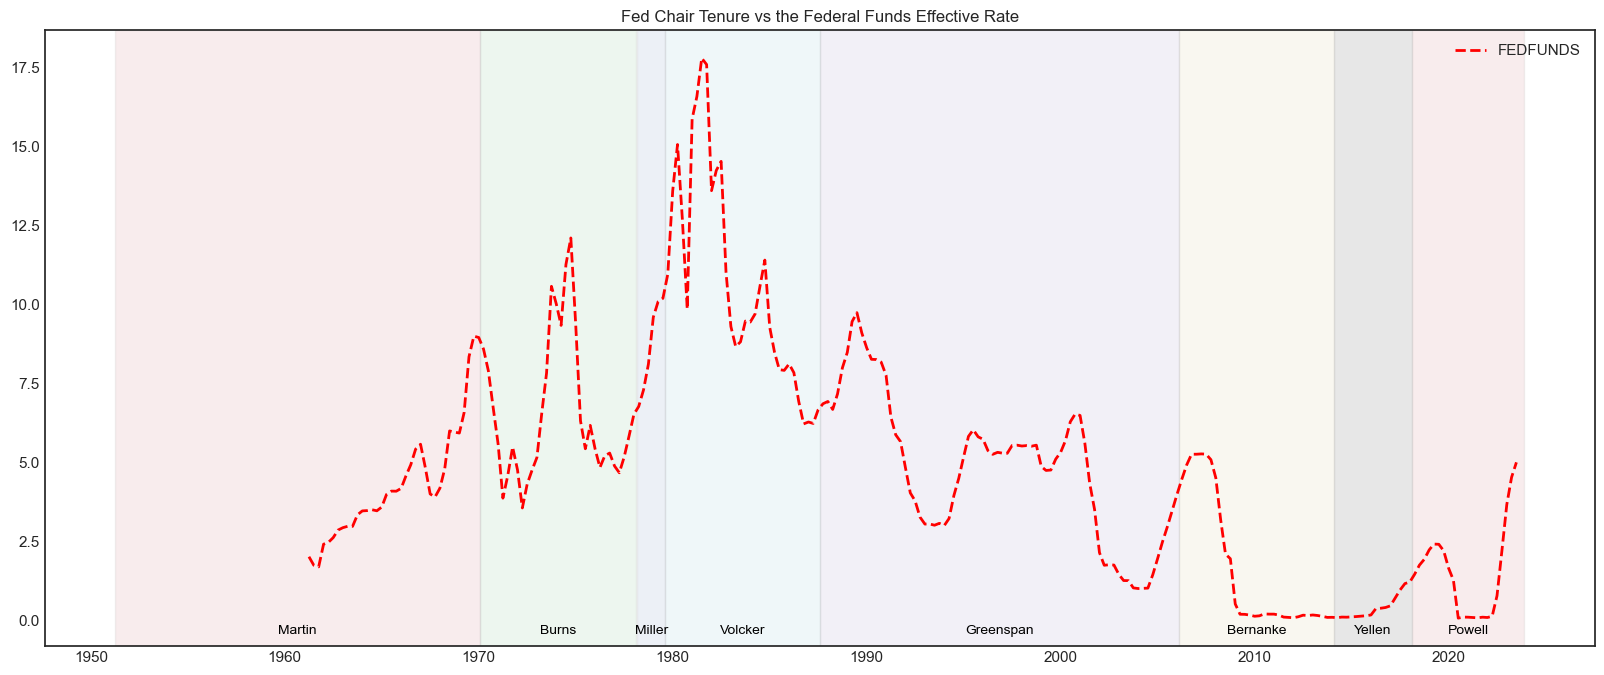

In [157]:
cycol = cycle('rgbcmyk')
min_value = m_df[['FEDFUNDS','m_index']].values.min()-0.5


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], color='red', linestyle='--',linewidth=2)
#ax.plot(m_df.index, m_df['m_index'], linestyle='--', color='gray',linewidth=1.5) 
    
# Plotting Chair Tenure
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=10, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS"])
#plt.legend()
plt.grid(False)
ax.set(title='Fed Chair Tenure vs the Federal Funds Effective Rate');
plt.show()

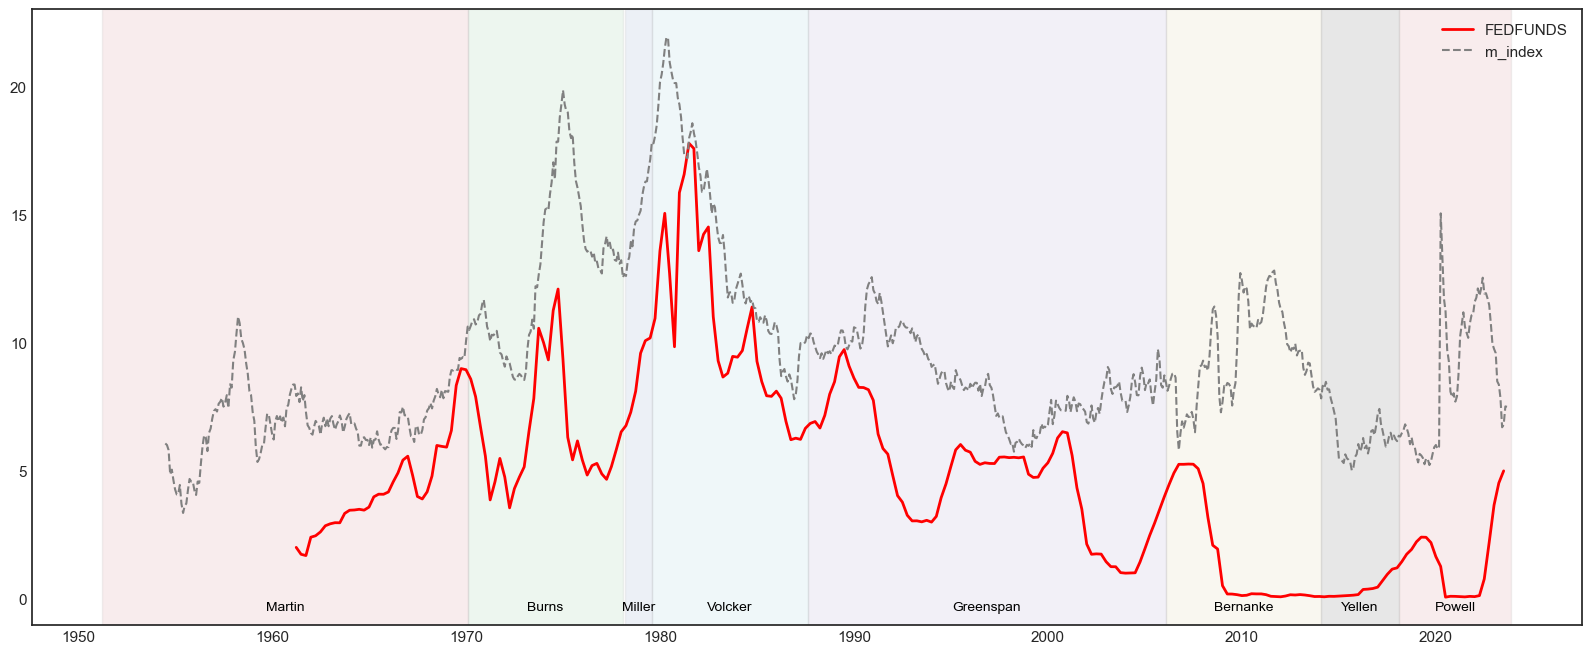

In [158]:
cycol = cycle('rgbcmyk')
min_value = m_df[['FEDFUNDS','m_index']].values.min()-0.5


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], color='red',linewidth=2)
ax.plot(m_df.index, m_df['m_index'], linestyle='--', color='gray',linewidth=1.5) 
    
# Plotting Chair Tenure
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=10, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","m_index"])
#plt.legend()
plt.grid(False)
plt.show()

In [159]:
t_df[['FEDFUNDS','UNRATE','GDPDEF_PC1','gap_inf','gap_gdp','gap_ue','chair_name','Real_Interest_Rate','chair_index']].groupby('chair_name').mean().round(2).sort_values(by='chair_index')

,FEDFUNDS,UNRATE,GDPDEF_PC1,gap_inf,gap_gdp,gap_ue,Real_Interest_Rate,chair_index
chair_name,,,,,,,,
Martin,4.29,4.69,2.41,0.41,8.93,0.31,4.94,8.0
Burns,6.49,6.28,6.26,4.26,6.53,-1.28,3.80,9.0
Miller,8.66,5.97,7.33,5.33,8.62,-0.97,3.62,10.0
Volcker,10.69,7.75,5.35,3.35,4.49,-2.75,3.53,11.0
Greenspan,4.82,5.54,2.43,0.43,6.86,-0.54,3.06,12.0
Bernanke,1.57,7.29,1.90,-0.10,5.00,-2.29,1.31,13.0
Yellen,0.40,5.17,1.35,-0.65,5.80,-0.17,0.66,14.0
Powell,1.55,4.81,3.48,1.48,7.32,0.19,0.94,15.0


In [160]:
m_df.reset_index(inplace=True)

m_df['chair_name'] = None
m_df['chair_index'] = 0
for i, row in chair_df.iterrows():
    m_df['chair_name'] = m_df['chair_name'].where((m_df['DATE'] < row['Start_Date']) | (m_df['DATE'] > row['End_Date']), row['Name'] )
    m_df['chair_index'] = m_df['chair_index'].where((m_df['DATE'] < row['Start_Date']) | (m_df['DATE'] > row['End_Date']), i )

m_df.set_index('DATE',inplace=True)

In [161]:
df = m_df[['FEDFUNDS','UNRATE','CPIAUCSL_PC1','m_index','chair_name']].groupby('chair_name').mean().round(2).sort_values(by='m_index', ascending=False)
df

,FEDFUNDS,UNRATE,CPIAUCSL_PC1,m_index
chair_name,,,,
Miller,9.24,5.89,9.23,15.12
Volcker,10.61,7.75,6.17,13.93
Burns,6.47,6.31,6.52,12.82
Bernanke,1.53,7.31,2.22,9.52
Greenspan,4.80,5.53,3.09,8.62
Powell,1.72,4.78,3.79,8.57
Martin,3.57,4.88,2.05,6.93
Yellen,0.46,5.06,1.32,6.38


# Models

## Load Data

In [162]:
taylor_df = load_taylor()
train_df = taylor_df
#train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)


In [163]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

In [164]:
X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','recession_flag','chair_name']]
y_train = train_df['FEDFUNDS']


#X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','recession_flag','chair_name']]
#y_test = test_df['FEDFUNDS']

In [165]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag','chair_name']
num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [166]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (250, 11)


X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_trf: ', X_test_trf.shape)

X_test_trf.info()

## Stats Model - Taylor Index

In [167]:
X_train_const = sm.add_constant(X_train_trf)
print('X_train_const: ', X_train_const.shape)

X_train_const:  (250, 12)


In [168]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     473.4
Date:                Thu, 23 Nov 2023   Prob (F-statistic):          6.40e-155
Time:                        23:12:42   Log-Likelihood:                -289.40
No. Observations:                 250   AIC:                             602.8
Df Residuals:                     238   BIC:                             645.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        0.5988      0.178      3.357      0.001       0.247       0.950
num__FEDFUNDS-1                              0.8729      0.033     26.845      0.000       0.809       0.937
num__gap_inf                                 0.1634      0.040      4.127      0.000       0.085       0.241
num__gap_ue                                  0.2009      0.040      5.057      0.000       0.123       0.279
cat__onehotencoder__recession_flag_True     -0.7225      0.187     -3.862      0.000      -1.091      -0.354
cat__onehotencoder__chair_name_Burns        -0.0982      0.242     -0.406      0.685      -0.575       0.378
cat__onehotencoder__chair_name_Miller        0.3598      0.392      0.918      0.360      -0.413       1.132
cat__onehotencoder__chair_name_Volcker       0.8270      0.305      2.714      0.007       0.227       1.427
cat__onehotencoder__chair_name_Greenspan     0.0691      0.167      0.415      0.679      -0.259       0.397
cat__onehotencoder__chair_name_Bernanke      0.1061      0.226      0.470      0.639      -0.339       0.551
cat__onehotencoder__chair_name_Yellen       -0.3468      0.257     -1.348      0.179      -0.853       0.160
cat__onehotencoder__chair_name_Powell       -0.4992      0.244     -2.047      0.042      -0.980      -0.019
==============================================================================
Omnibus:                       64.513   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1083.816
Skew:                           0.441   Prob(JB):                    4.49e-236
Kurtosis:                      13.162   Cond. No.                         63.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [170]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], 2 , model_stats_df )

### Test

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], 2 , model_stats_df )

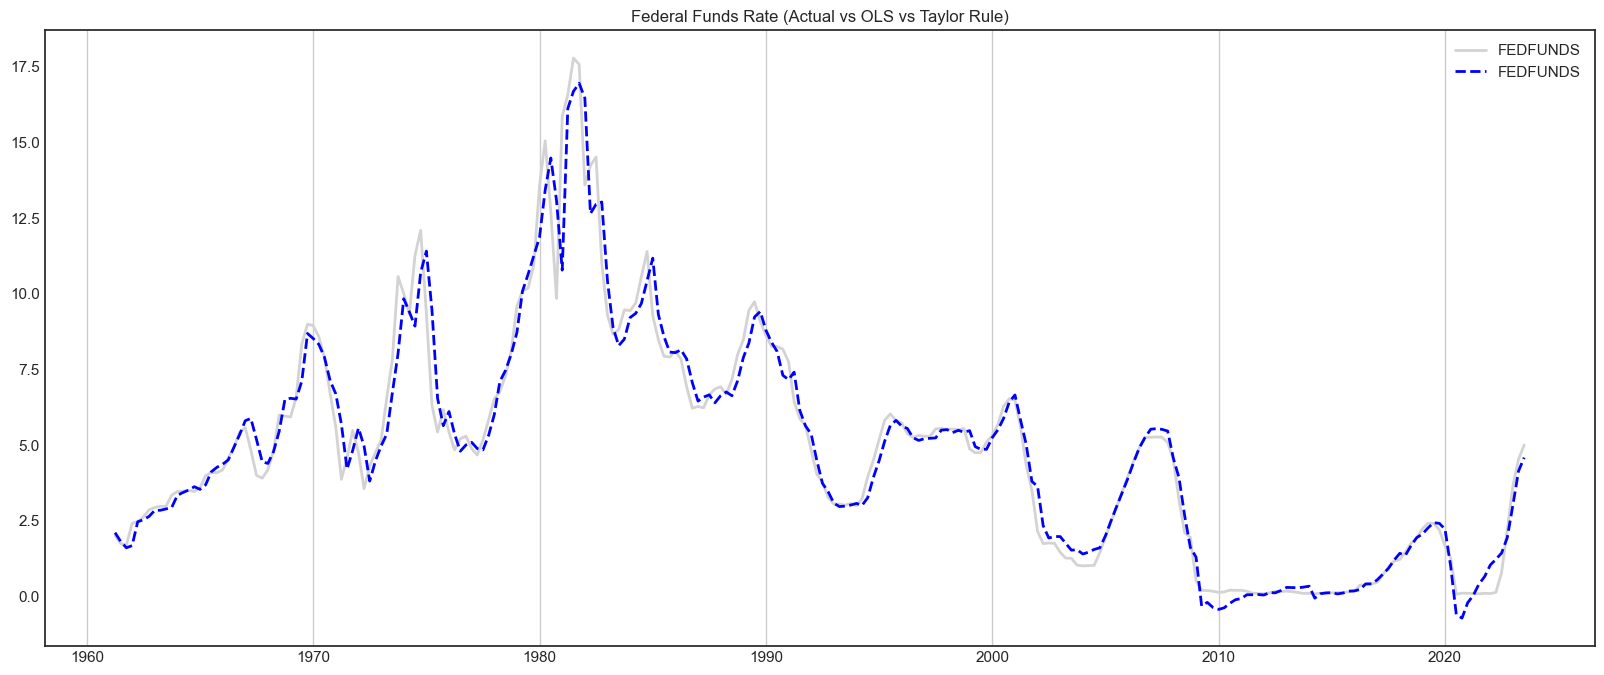

In [171]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
#ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
#ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# Lasso

In [172]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.03267557476973939


In [173]:
lasso_best = linear_model.Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [174]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,coef
num__FEDFUNDS-1,0.945705
cat__onehotencoder__recession_flag_True,-0.450200
num__gap_ue,0.106437
num__gap_inf,0.101010
cat__onehotencoder__chair_name_Burns,-0.000000
cat__onehotencoder__chair_name_Miller,0.000000
cat__onehotencoder__chair_name_Volcker,0.000000
cat__onehotencoder__chair_name_Greenspan,-0.000000
cat__onehotencoder__chair_name_Bernanke,0.000000
cat__onehotencoder__chair_name_Yellen,-0.000000


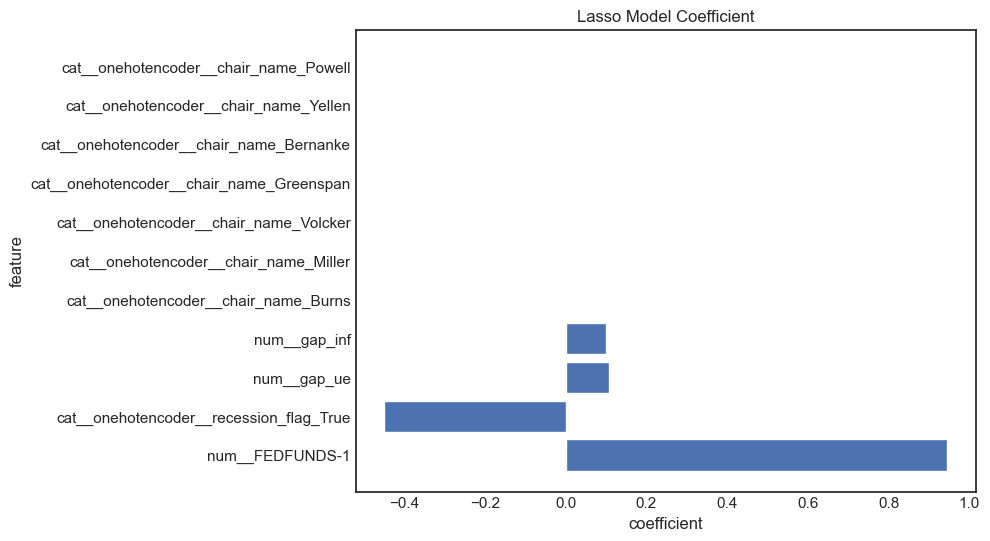

In [175]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [176]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], 2 , model_stats_df )

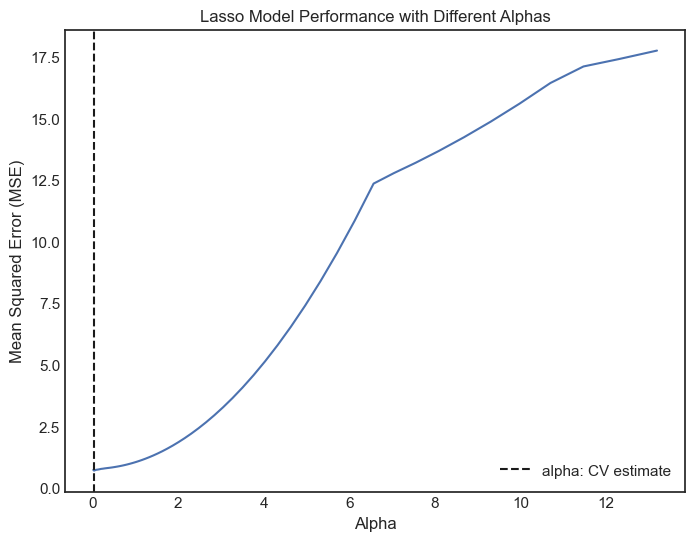

In [177]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

(-0.6457085511756002, 13.8500856651036, -2.2672429810573655, 50.64711962034137)

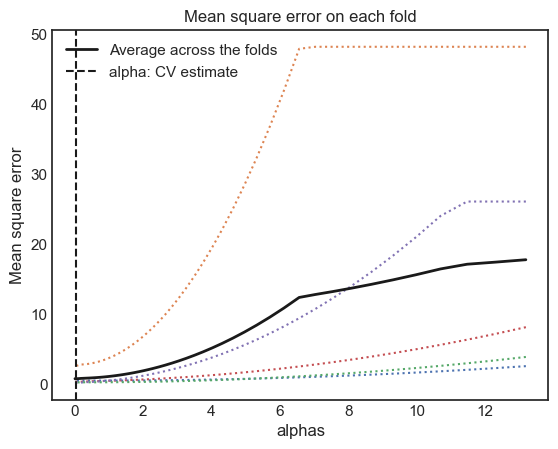

In [178]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

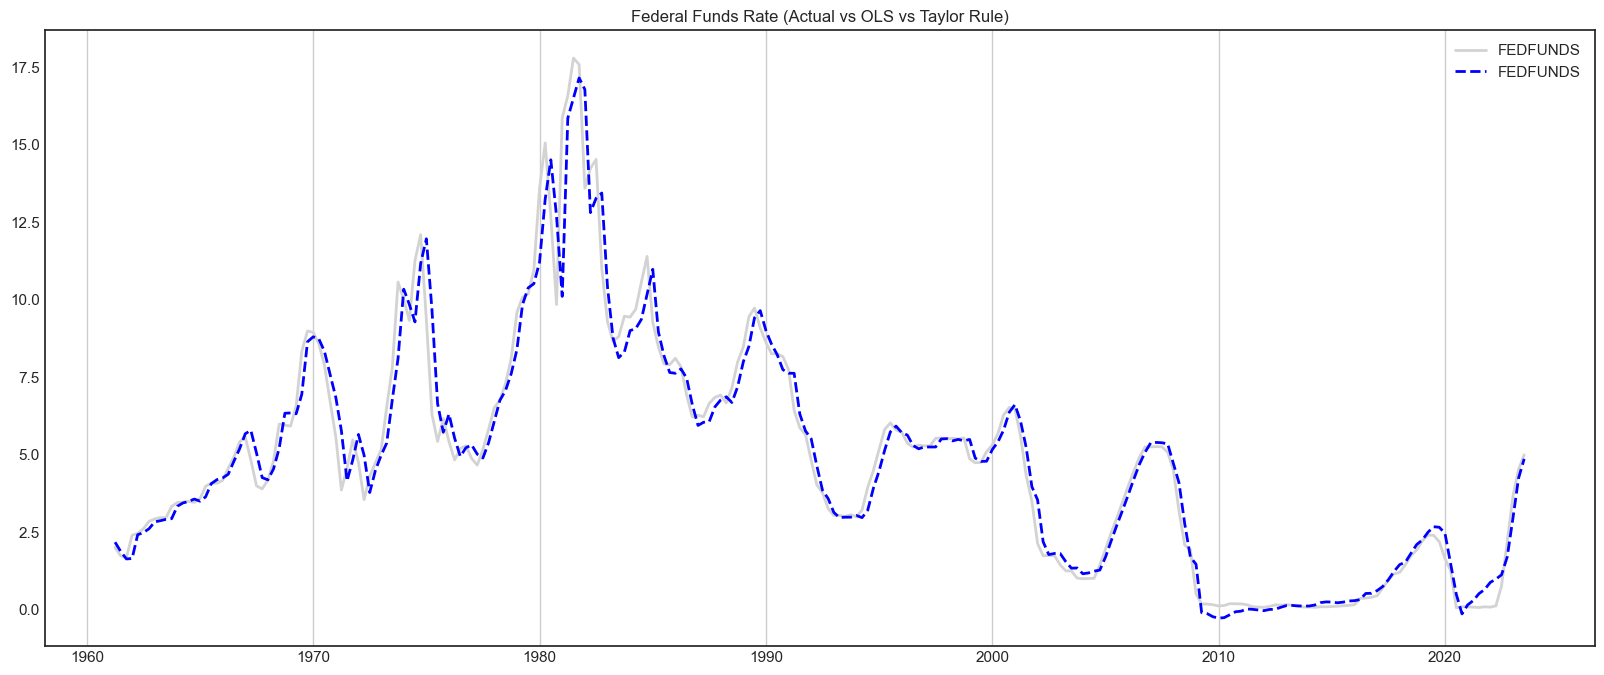

In [179]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
#ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
#ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [180]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

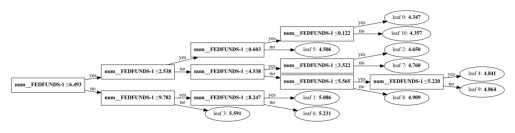

In [181]:
ltb.plot_tree(ltb_model)

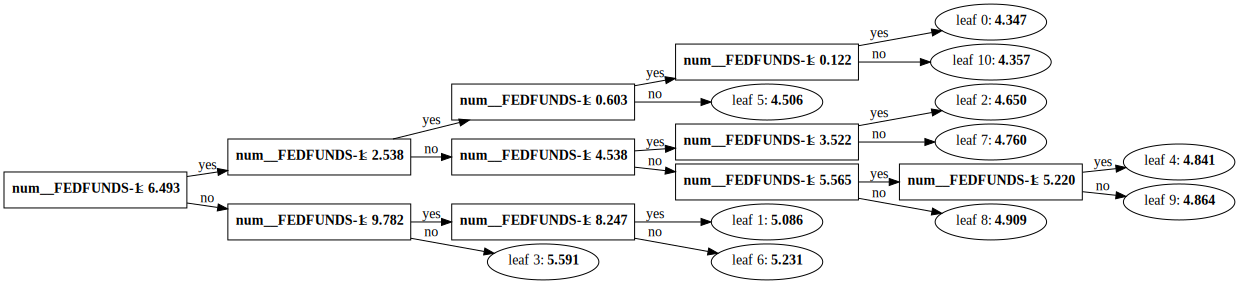

In [182]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

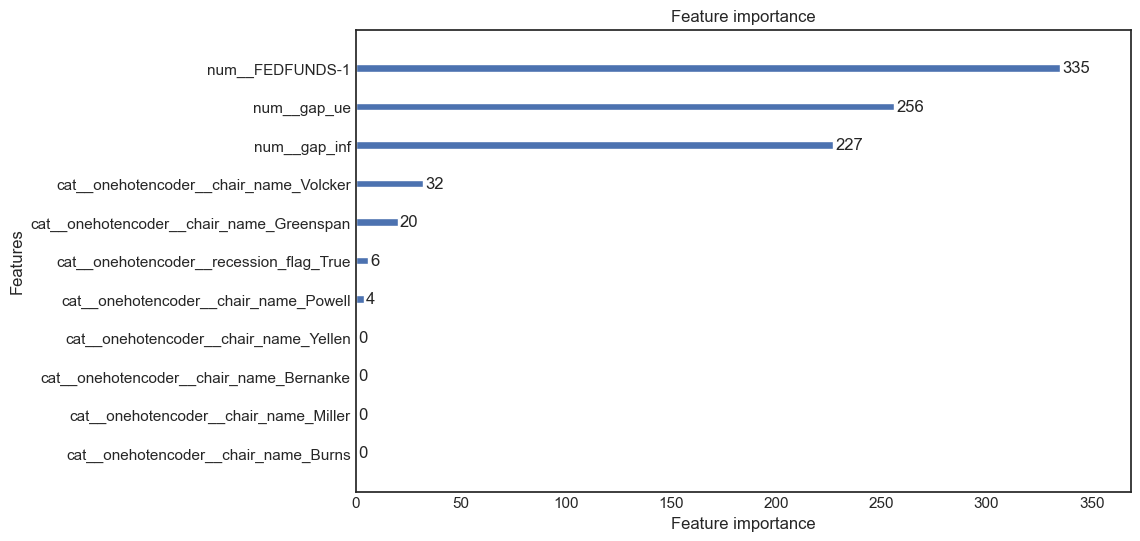

In [183]:
ltb.plot_importance(ltb_model, ignore_zero=False, grid=False, figsize=(10,6))

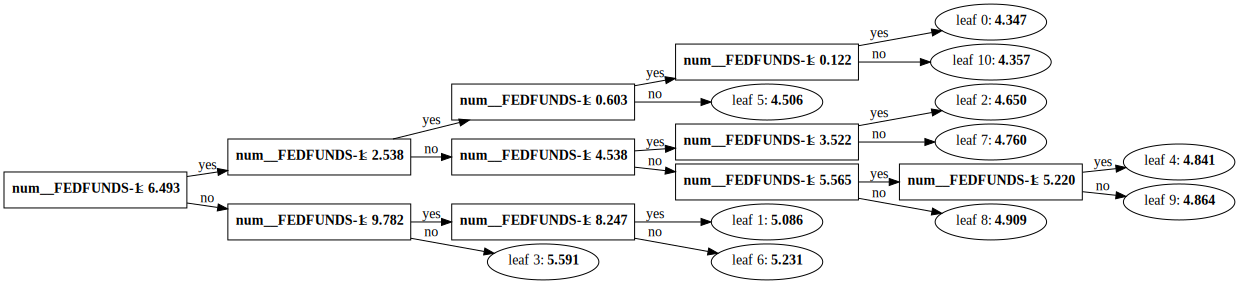

In [184]:
ltb.create_tree_digraph(ltb_model)

In [185]:
feature_df = pd.DataFrame({'feature_name': preprocessor.get_feature_names_out(),
                           'feature_importance': ltb_model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,feature_name,feature_importance
0,num__FEDFUNDS-1,335
2,num__gap_ue,256
1,num__gap_inf,227
6,cat__onehotencoder__chair_name_Volcker,32
7,cat__onehotencoder__chair_name_Greenspan,20
3,cat__onehotencoder__recession_flag_True,6
10,cat__onehotencoder__chair_name_Powell,4
4,cat__onehotencoder__chair_name_Burns,0
5,cat__onehotencoder__chair_name_Miller,0
8,cat__onehotencoder__chair_name_Bernanke,0


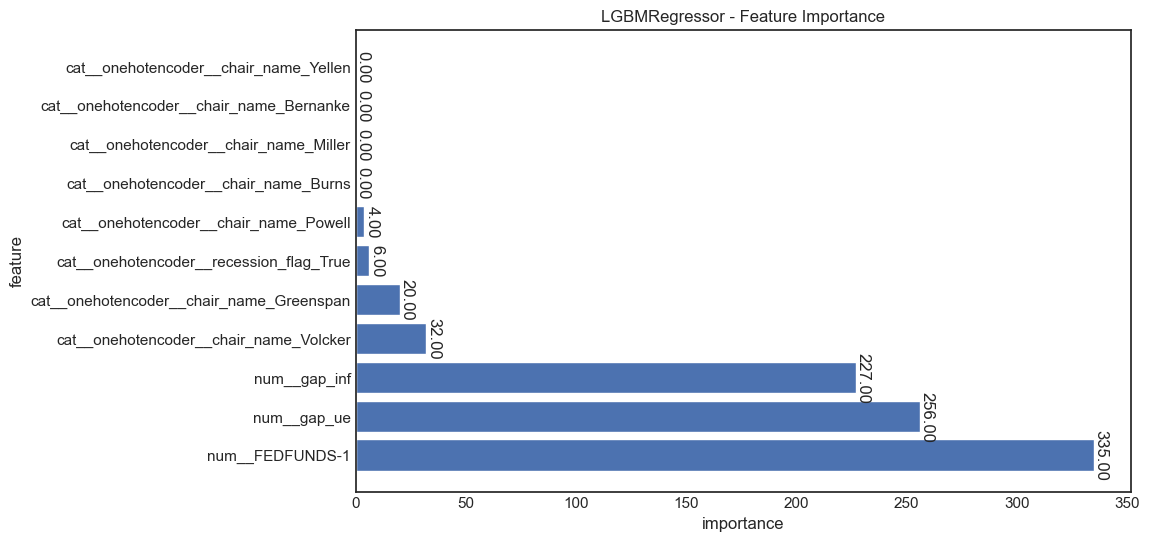

In [186]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

In [187]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], 2  , model_stats_df )

# Sharpe

In [188]:
model = ltb_model
model

LGBMRegressor(verbose=-1)

In [189]:
explainer = None
shap_values = None

In [190]:
try:
    explainer = shap.Explainer(ltb_model, X_train_trf)
    shap_values = explainer(X_train_trf)
except Exception as e:
    print('-- error ')
    print(e)

-- error 
Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 7.149104, while the model output was 6.854415. If this difference is acceptable you can set check_additivity=False to disable this check.


In [191]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

In [192]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_train_trf, plot_size=(16,8))

In [193]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


In [194]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

## Test

test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_train.shape[0], 2 , model_stats_df )

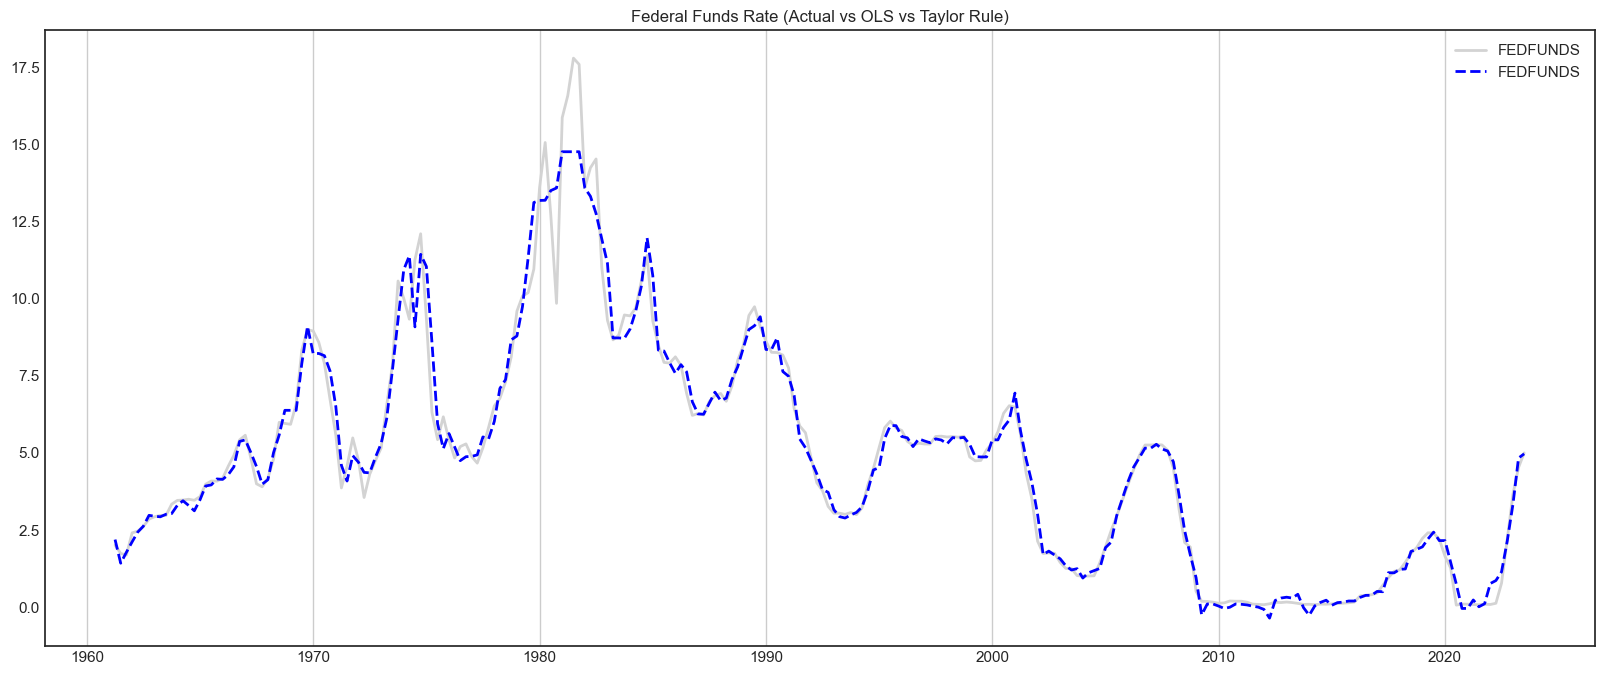

In [195]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
#ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
#ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [196]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9999985819363796

In [197]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], 2 , model_stats_df )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

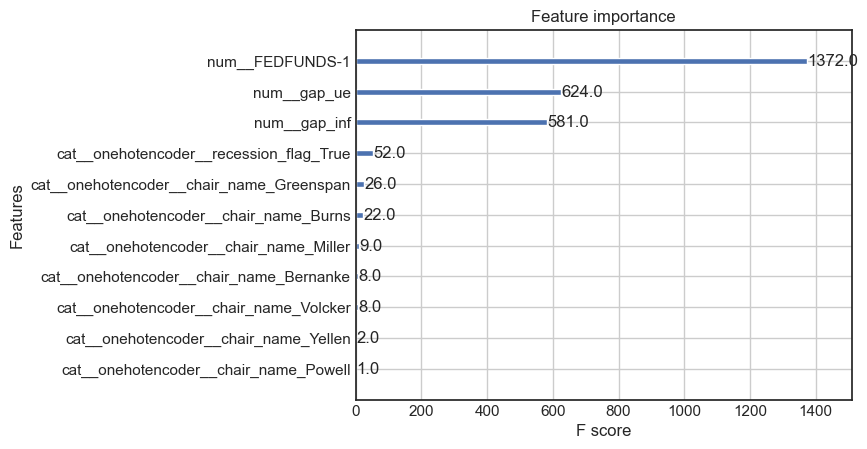

In [198]:
xgb.plot_importance(xgb_model)

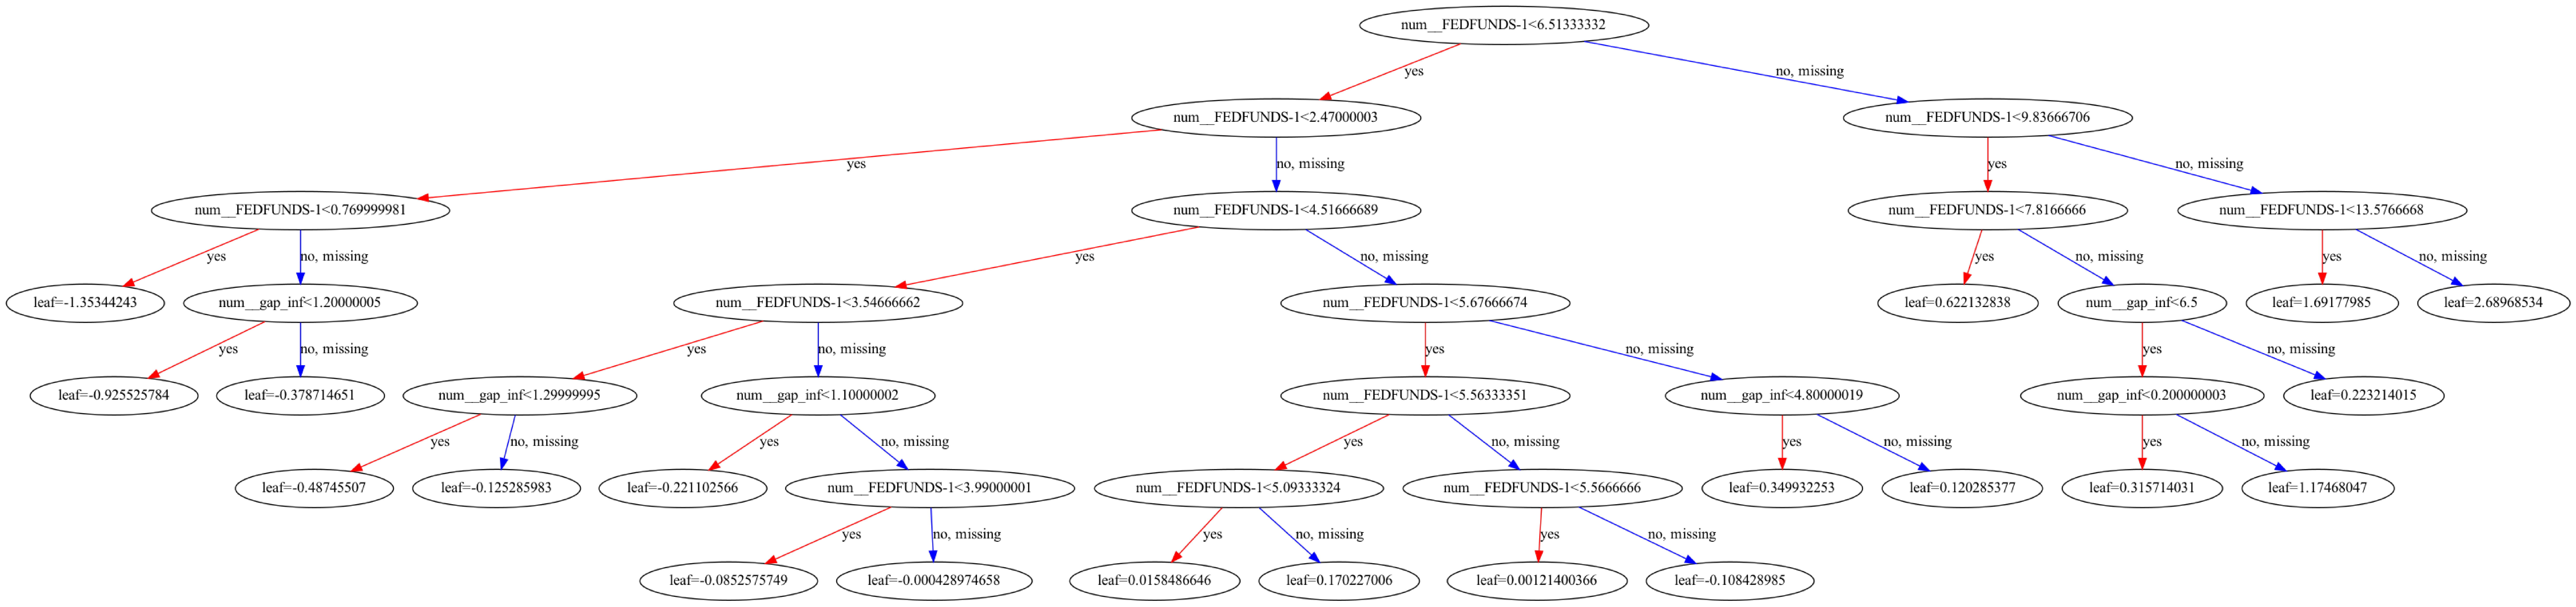

In [199]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

In [200]:
explainer = None
shap_values = None

In [201]:
try:
    explainer = shap.Explainer(xgb_model, X_train_trf)
    shap_values = explainer(X_train_trf)
except Exception as e:
    print('-- error ')
    print(e)

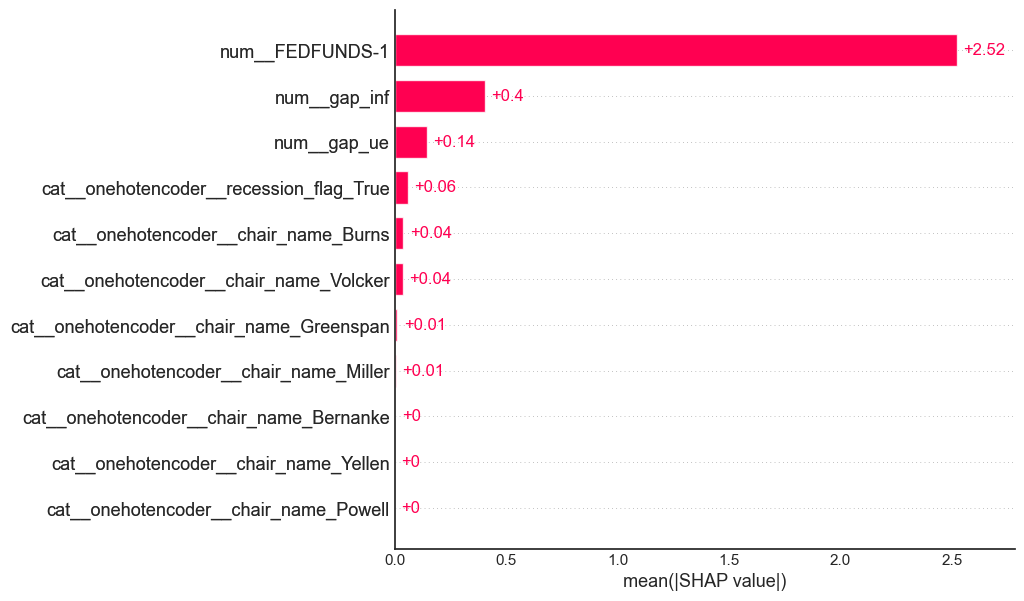

In [202]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

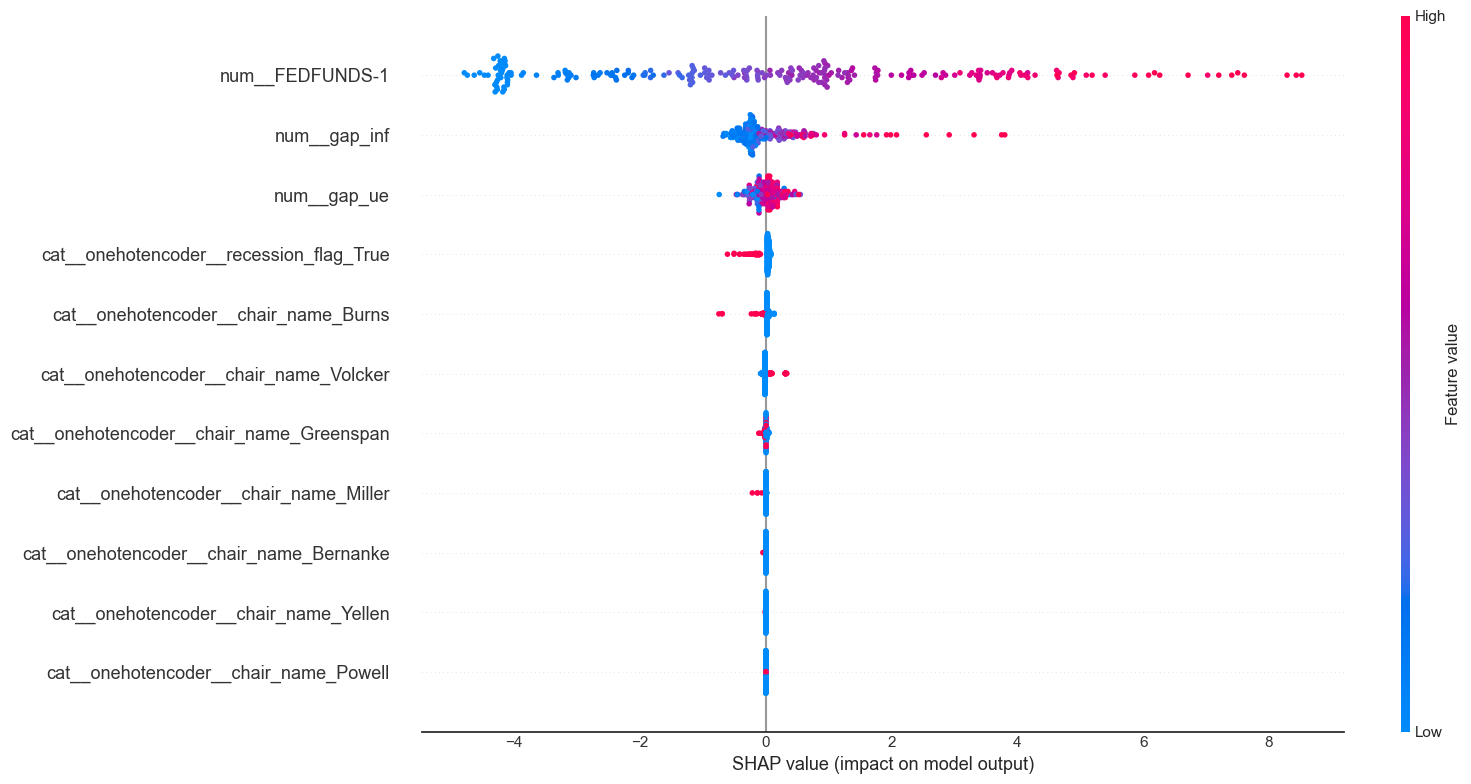

In [203]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_train_trf, plot_size=(16,8))

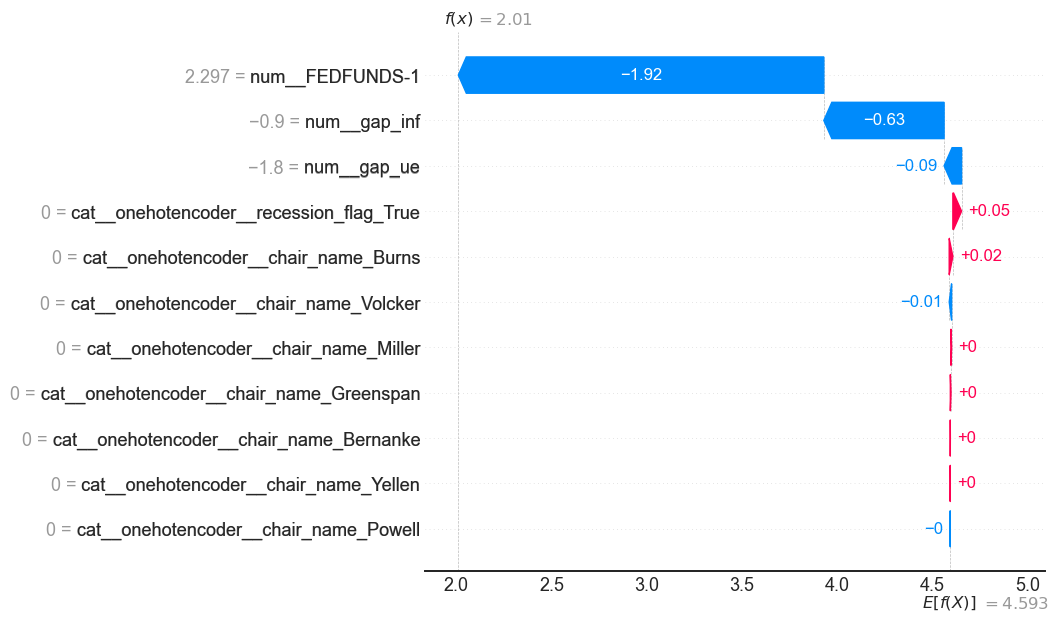

In [204]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


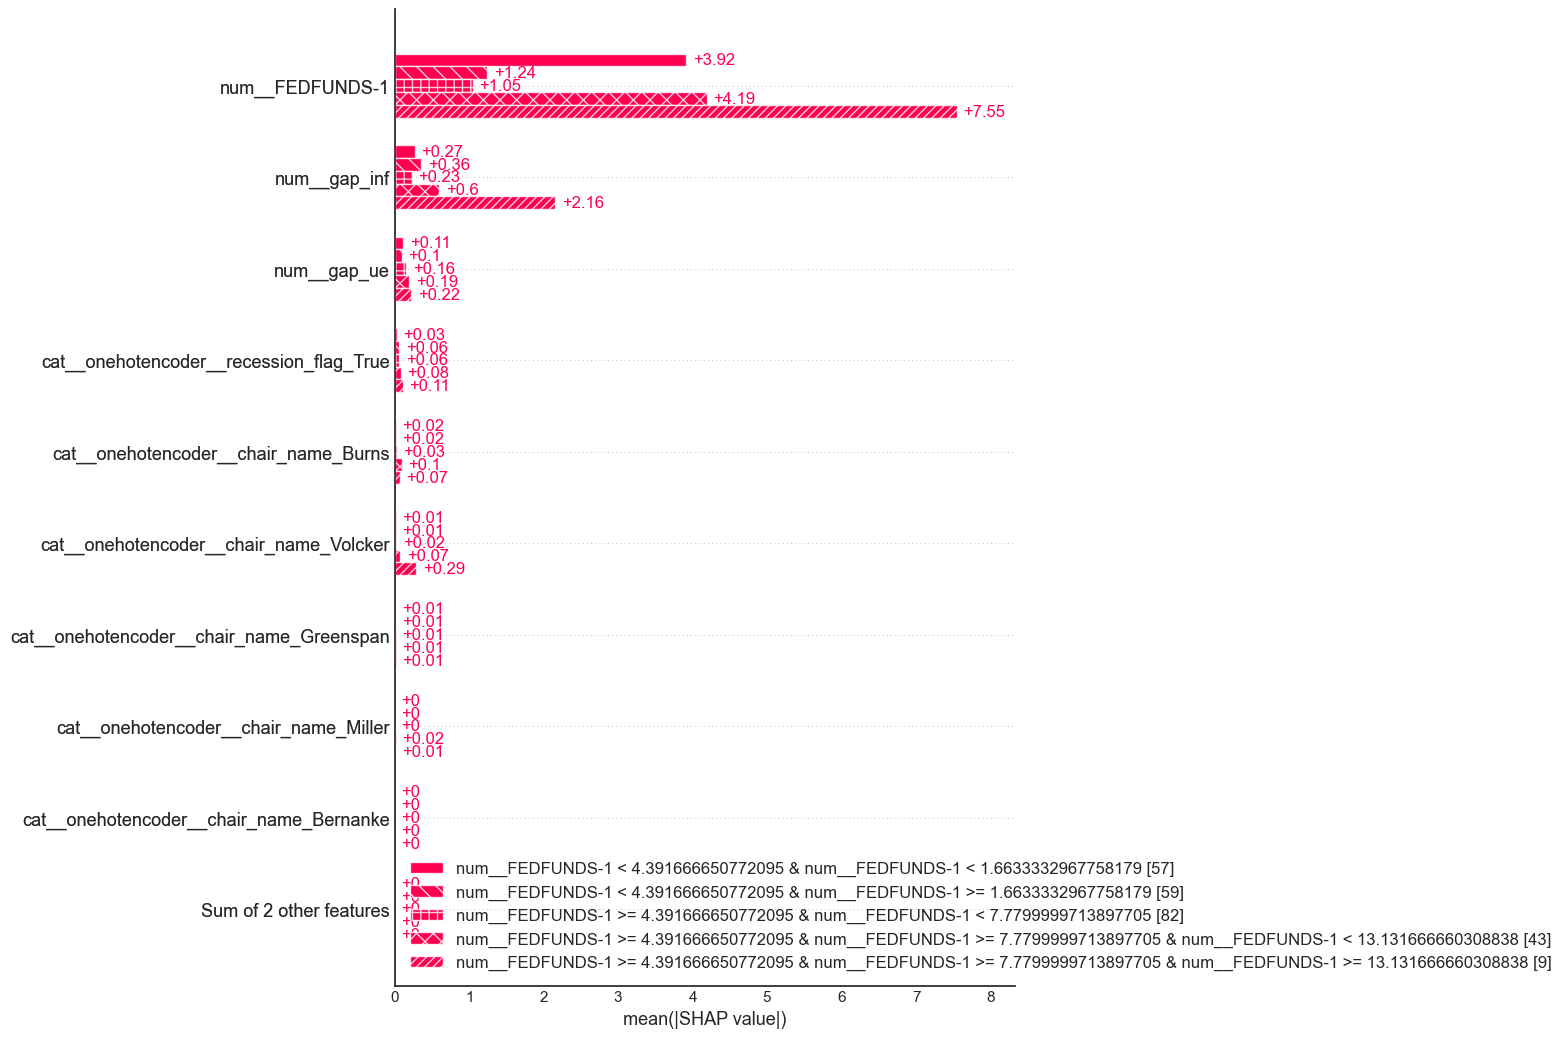

In [205]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

## Test

test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

model_stats_df = model_results('xgb_test', y_test, test_pred_xgb, X_train.shape[0], 2 , model_stats_df )

# AdaBoostRegressor

In [206]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

test_pred_ada = ada_model.predict(X_test_trf)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

# tsa.SARIMAX

In [207]:
model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  250
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -292.176
Date:                Thu, 23 Nov 2023   AIC                            610.352
Time:                        23:12:53   BIC                            656.131
Sample:                    03-31-1961   HQIC                           628.777
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
num__FEDFUNDS-1                              0.9172      0.042     22.037      0.000       0.836       0.999
num__gap_inf                                 0.1383      0.043      3.235      0.001       0.054       0.222
num__gap_ue                                  0.1994      0.057      3.528      0.000       0.089       0.310
cat__onehotencoder__recession_flag_True     -0.7761      0.181     -4.283      0.000      -1.131      -0.421
cat__onehotencoder__chair_name_Burns         0.3296      0.280      1.177      0.239      -0.219       0.879
cat__onehotencoder__chair_name_Miller        0.6897      0.715      0.965      0.335      -0.712       2.091
cat__onehotencoder__chair_name_Volcker       1.0389      0.448      2.317      0.020       0.160       1.917
cat__onehotencoder__chair_name_Greenspan     0.4677      0.308      1.520      0.129      -0.135       1.071
cat__onehotencoder__chair_name_Bernanke      0.6298      0.398      1.582      0.114      -0.150       1.410
cat__onehotencoder__chair_name_Yellen        0.2205      1.960      0.113      0.910      -3.620       4.061
cat__onehotencoder__chair_name_Powell        0.0846      0.388      0.218      0.827      -0.676       0.845
ar.L1                                        0.1721      0.056      3.094      0.002       0.063       0.281
sigma2                                       0.6062      0.034     18.039      0.000       0.540       0.672
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              2118.92
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [208]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [209]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1961-03-31,1.623161,0.790369,0.074067,3.172254
1961-06-30,1.314237,0.790369,-0.234857,2.863331
1961-09-30,1.099294,0.790369,-0.449800,2.648388
1961-12-31,1.166425,0.790369,-0.382669,2.715519
1962-03-31,1.978215,0.790369,0.429121,3.527309
...,...,...,...,...
2022-06-30,1.261864,0.790369,-0.287230,2.810958
2022-09-30,1.809388,0.790369,0.260295,3.358482
2022-12-31,2.980737,0.790369,1.431643,4.529831
2023-03-31,4.190767,0.790369,2.641673,5.739860


In [210]:
model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0],X_train.shape[1] , model_stats_df )

## Test

s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_train.shape[1] , model_stats_df )

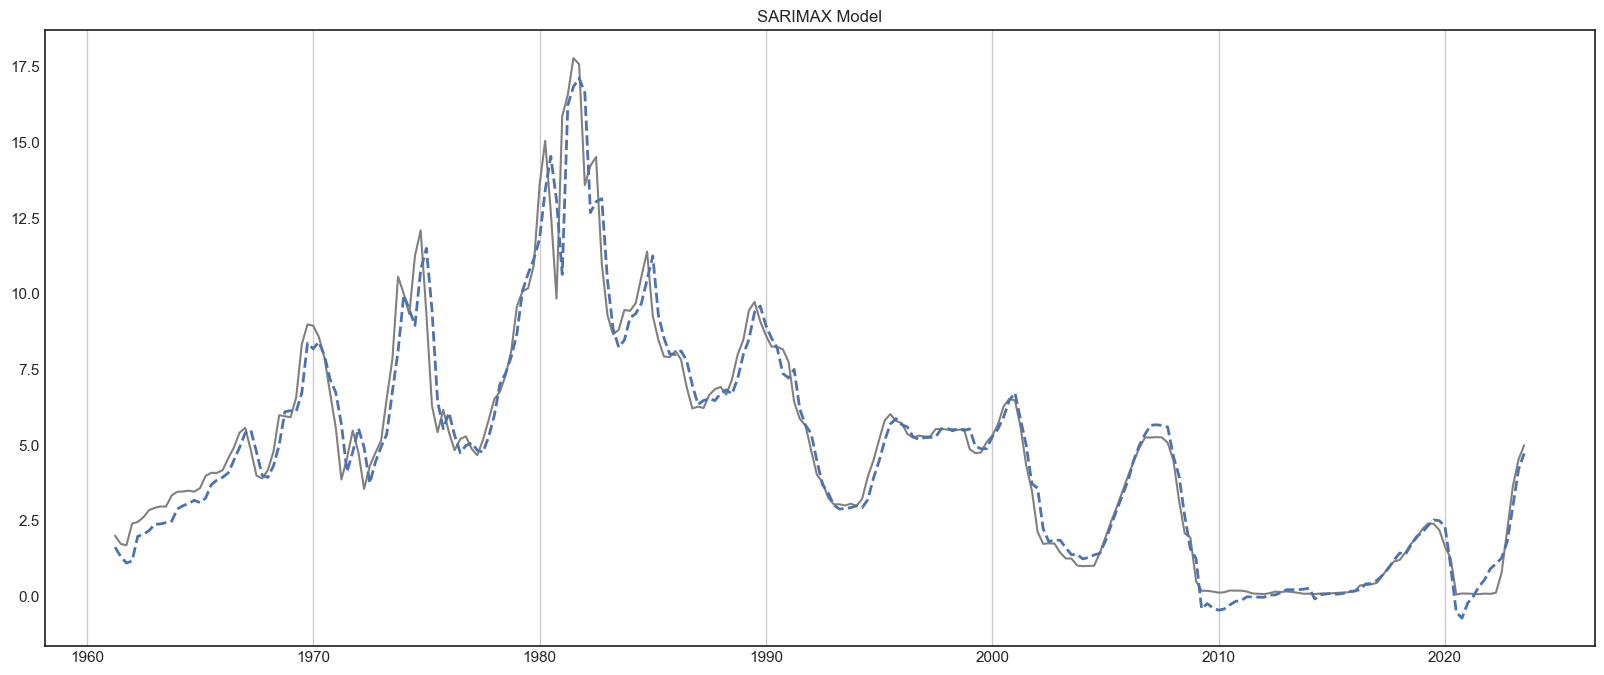

In [211]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
#ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
#ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
#ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [212]:
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002
6,ols_train,0.9563,0.9561,0.5929,0.7700
7,lasso_train,0.9523,0.9522,0.6464,0.8040
8,lgbm_train,0.9710,0.9709,0.3931,0.6270
9,xgb_train,1.0000,1.0000,0.0000,0.0044
